# SVM



## Data length is important - learning curves

### Correlation value

## Correlaction might say anything about which kernel will work the best

### Kernels and params distribution across the stocks 

## Conclusions

SVM is better than coin toss, but it's better than logistic regression in about 50% of cases only.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn import preprocessing

import warnings

from lob_data_utils import lob, db_result

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

#### 15000

In [2]:
data_length = 15000
df_res_cv = pd.DataFrame(db_result.get_svm_results_for_data_length(data_length, 'cv'))

dfs = {}
dfs_test = {}
dfs_cv = {}

stocks = df_res_cv['stock'].unique()

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, cv=True, length=data_length)
    dfs[s] = d
    dfs_test[s] = d_test
    
df_res_cv.drop('algorithm_id', axis=1, inplace=True)
df_res_cv.drop('svm_id', axis=1, inplace=True)
df_res_cv.drop('id', axis=1, inplace=True)
df_res_cv.drop('data_length', axis=1, inplace=True)
df_res_cv.drop('name', axis=1, inplace=True)
df_res_cv.drop('data_type', axis=1, inplace=True)
df_res_cv.head()

bests = []
df_best_agg = df_res_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_res_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']

In [3]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
bid_len = []
ask_len = []
mean_bid_ask_len = []
mean_bid_len = []
mean_ask_len = []

for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

    max_len_bid = 0
    max_len_ask = 0
        
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])
    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)

    sum_len_bid_ask = 0
    sum_len_bid = 0
    sum_len_ask = 0
    for i, row in dfs[s].iterrows():
        sum_len_bid_ask += (len(row['ask']) + len(row['bid']))
        sum_len_bid += len(row['bid'])
        sum_len_ask += len(row['ask'])
    mean_bid_ask_len.append(sum_len_bid_ask/(2 * len(dfs[s])))
    mean_bid_len.append(sum_len_bid/len(dfs[s]))
    mean_ask_len.append(sum_len_ask/len(dfs[s]))
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['max_len_ask'] = ask_len
df_summary['max_len_bid'] = bid_len
df_summary['mean_bid_ask_len'] = mean_bid_ask_len
df_summary['mean_bid_len'] = mean_bid_len
df_summary['mean_ask_len'] = mean_ask_len

In [4]:
df_bests.sort_index(inplace=True)
df_summary.sort_index(inplace=True)
df_summary = df_bests.join(df_summary)
le = preprocessing.LabelEncoder()
le.fit(["linear", 'sigmoid', "rbf"])
df_summary['kernel_class'] = le.transform(df_summary['kernel'])

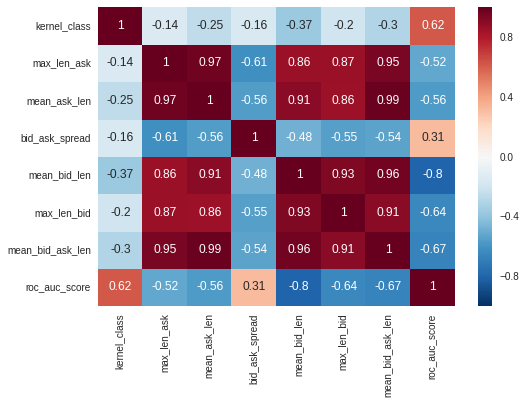

In [5]:
features = list(set(list(df_summary.columns)) - {'c', 'gamma', 'coef0'} - 
                {'sum_sell_ask_mean', 'sum_buy_bid_mean', 'max_trade_price', 'min_trade_price'})
sns.heatmap(df_summary[features].corr(), annot=True)

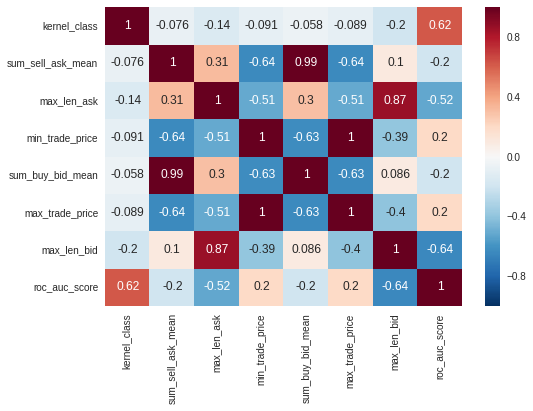

In [6]:
features = list(set(list(df_summary.columns)) - {'c', 'gamma', 'coef0'} - 
                {'mean_ask_len', 'mean_bid_len', 'mean_bid_ask_len', 'bid_ask_spread'})
sns.heatmap(df_summary[features].corr(), annot=True)

Violin plots have many of the same summary statistics as box plots:

    the white dot represents the median
    the thick gray bar in the center represents the interquartile range
    the thin gray line represents the 95% confidence interval

On each side of the gray line is a kernel density estimation to show the distribution shape of the data. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.

(500, 2500)

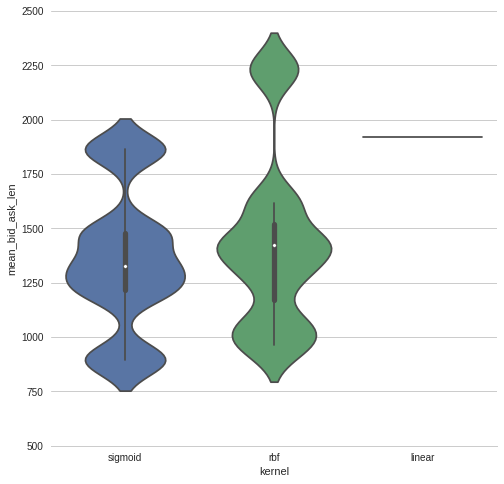

In [26]:
f, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(x='kernel', 
           y='mean_bid_ask_len', data=df_summary, cut=2, bw=0.2)
sns.despine(left=True)

### Metrics worth trying:
* max_len_bid, max_len_ask (probably mean is ok)
* mean_bid_ask_len or something similar with mean_bid_len and mean_ask_len

We want to know how to pick the right kernel

In [ ]:
features = ['max_len_bid', 'max_len_ask', 'mean_bid_ask_len']
kmeans = KMeans(n_clusters=3, random_state=17).fit_predict(df_summary[['mean_bid_ask_len']])
df_summary['kmeans_class'] = kmeans
df_summary.groupby(['kernel', 'kmeans_class'])['kernel'].count().plot(kind='bar')

In [ ]:
df_summary.groupby(['kernel'])['kernel'].count().plot(kind='bar')

In [ ]:
df_summary.groupby(['kmeans_class'])['kmeans_class'].count().plot(kind='bar')